In [ ]:
#upload kaggle.json
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples

In [ ]:
!unzip /content/makeup-lips-segmentation-28k-samples.zip

In [ ]:
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2

from sklearn.model_selection import train_test_split

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [ ]:
img_path = '/content/set-lipstick-original/720p'
mask_path = '/content/set-lipstick-original/mask'
data = pd.read_csv('/content/set-lipstick-original/list.csv')

In [ ]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [ ]:
imgs_set = set(os.listdir(img_path))
masks_set = set(os.listdir(mask_path))

imgs_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in imgs_set)
masks_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in masks_set)

not_mask = imgs_set.difference(masks_set)

not_mask = [f'image{i}.jpg' for i in not_mask]

In [ ]:
data = data.loc[~data['filename'].isin(not_mask)]
data.reset_index(drop=True, inplace=True)

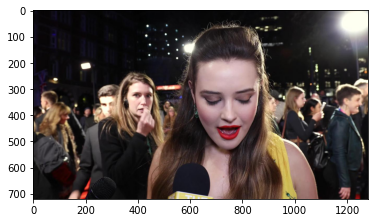

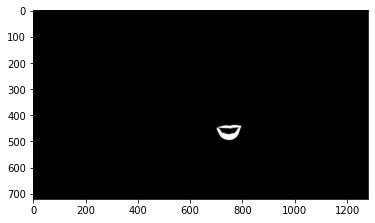

In [ ]:
idx = 1030

sample = data.iloc[idx]

img_path = os.path.join(img_path, sample['filename'])
mask_path = os.path.join(mask_path, sample['mask'])

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
mask = cv2.imread(mask_path)[:, :, 1]

plt.imshow(img)
plt.show()

plt.imshow(mask, cmap='gray')
plt.show()

In [ ]:
class Lips_Segmentation_Dataset(Dataset):
    def __init__(self, images, labels, data):
        self.images = images
        self.labels = labels
        self.data = data
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        datta = self.data.iloc[index]

        img_path = os.path.join('/content/set-lipstick-original/720p', datta['filename'])
        mask_path = os.path.join('/content/set-lipstick-original/mask', datta['mask'])


        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # resize image
        image = cv2.resize(image,(300,300))
        image /= 255.0
        
        # load label
        label = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # resize image
        label = cv2.resize(label,(300,300))
        # set image to 0 for background, else 1 for body area
        label[label>0] = 1
        
        image = torch.as_tensor(image, dtype=torch.float32)
        # torch accept (c, h, w)
        image = torch.permute(image,(2,0,1))
        label = torch.as_tensor(label, dtype=torch.long)
        return image, label

In [ ]:
# extract image list
X = data['filename']
y = X.copy()

# split train and validate set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

# set parameter
BATCH_SIZE = 8
device = torch.device('cuda')
lr_rate = 2e-5
EPOCH = 4

In [ ]:
# load train dataset
train_dataset = Lips_Segmentation_Dataset(images=X_train, 
                              labels=y_train,
                              data=data)
train_data_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)

# load validate dataset
val_dataset = Lips_Segmentation_Dataset(images=X_val,
                            labels=y_val,
                            data=data)
val_data_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_fn(data_loader, model, optimizer, criterion, device, epoch):
    model.train()
    
    # class to save loss
    summary_loss = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking=True).float()
        labels = labels.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(images)
        # calculate loss
        loss = criterion(outputs, labels)
        
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save loss value
        summary_loss.update(loss.item(), BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg, epoch=epoch+1)
    return summary_loss

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    
    # class to save loss
    summary_loss = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking=True).float()
        labels = labels.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # save loss value
        summary_loss.update(loss.item(), BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg,epoch=epoch+1)
    return summary_loss


In [ ]:
def run():
    # Load pretrained model
    model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.CrossEntropyLoss()
    best_loss = 10**5
    for epoch in range(0,EPOCH):
        train_loss = train_fn(train_data_loader, model, optimizer, criterion, device, epoch)
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)
        # Check if val_loss is less than best_loss
        if val_loss.avg < best_loss:
            # Update best loss
            best_loss = val_loss.avg
            # Save model
            torch.save(model.state_dict(), f'best.pth')

In [ ]:
run()

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_car

  0%|          | 0.00/118M [00:00<?, ?B/s]

100%|██████████| 714/714 [03:08<00:00,  3.79it/s, epoch=4, loss=0.00122]


In [ ]:
model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=False, scale=0.5)
# load trained weight
model.load_state_dict(torch.load("./best.pth"))

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


<All keys matched successfully>

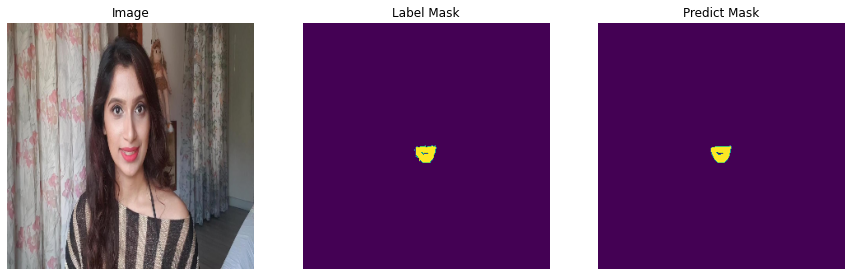

In [35]:
img, label = next(iter(val_data_loader))
pred = torch.permute(torch.argmax(model(torch.unsqueeze(img[0],dim=0)),1),(1,2,0)).detach().numpy()
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(torch.permute(img[0],(1,2,0)))
axs[0].set_title('Image')
axs[1].imshow(label[0].detach().numpy())
axs[1].set_title('Label Mask')
axs[2].imshow(np.squeeze(pred))
axs[2].set_title('Predict Mask')
for ax in axs:
    ax.axis('off')